In [174]:
import pandas as pd

In [175]:
df = pd.read_csv("C:/Users/Anja/Fronius/service_messages.csv")
df

,PvSystemId,Description,StatusCode,Connected,Riso,PerformanceRatio,Temp,IsHealthy
0,fcc00435-91a0-9ed8-98bb-2fbc357ce3b6,"Use the auxiliary EXE card, then you can input...",106,1,1,0.280170,27,False
1,0c53fa00-53f9-69d0-a7a6-30463e5e5ad8,"If we navigate the port, we can get to the SMS...",45,0,1,0.358354,2,False
2,ca68c058-fd88-8a4b-3887-f25b6c2ef743,"If we program the hard drive, we can get to th...",36,0,0,0.538403,29,False
3,4df37afc-d9a1-3718-5073-fd24b93e7d69,We need to parse the open-source EXE matrix!,117,1,0,0.209437,26,False
4,b948b18e-b201-ec4d-9e2c-7f75c35b1723,We need to compress the primary EXE bus!,91,1,1,0.860023,5,False
...,...,...,...,...,...,...,...,...
99995,a072121c-f92a-a2b2-db7d-58086955137c,"The AI bandwidth is down, reboot the redundant...",19,0,1,0.495220,23,False
99996,13541ab4-f3d0-8fb3-2c8e-b8c83adf8282,"Try to transmit the PNG feed, maybe it will tr...",103,0,0,0.580165,1,False
99997,e500898d-669e-bef1-79a6-265ef33fccea,"I'll generate the neural SQL driver, that shou...",87,0,0,0.643387,11,False
99998,39a05bab-f015-3781-2876-a26370f53ab9,"The TCP panel is down, copy the neural panel s...",170,0,1,0.898279,-14,False


In [177]:
df.isna()
sum(df["StatusCode"].isnull())
sum(df["Connected"].isnull())
sum(df["Riso"].isnull())
sum(df["PerformanceRatio"].isnull())
sum(df["Temp"].isnull())

# After some analysis, I realised that dataset is fullfil and doesn't have missing or null values.
# ALso, PvSystemId, Description (they are unique) are not very relevant information for our Binary Classification.

0

In [182]:
# Here, X (training) dataset and Y (testing) dataset will be created.
# Status code values should be in range 0-1 (for better performance) as well as values of Temp column.
# Stanadard Scaling will take care for that.
from sklearn.preprocessing import StandardScaler

X = df.drop(['PvSystemId', 'Description', 'IsHealthy'], axis='columns')
X_StatusCode = StandardScaler().fit_transform(X[['StatusCode']])
X_Temp = StandardScaler().fit_transform(X[['Temp']])
X['StatusCode'] = X_StatusCode
X['Temp'] = X_Temp
X #traing dataset

,StatusCode,Connected,Riso,PerformanceRatio,Temp
0,0.098678,1,1,0.280170,0.968979
1,-0.957766,0,1,0.358354,-0.453619
2,-1.113635,0,0,0.538403,1.082787
3,0.289185,1,0,0.209437,0.912075
4,-0.161103,1,1,0.860023,-0.282907
...,...,...,...,...,...
99995,-1.408054,0,1,0.495220,0.741364
99996,0.046722,0,0,0.580165,-0.510523
99997,-0.230378,0,0,0.643387,0.058517
99998,1.207079,0,1,0.898279,-1.364081


In [183]:
# To create testing or our target dataset, LabelEncoider will be applied for converting boolean values into integers (0 & 1).
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
isHealthy = le.fit_transform(df['IsHealthy'])
Y = df.drop(columns=['PvSystemId', 'Description', 'StatusCode', 'Connected', 'Riso', 'PerformanceRatio', 'Temp'])
Y['IsHealthy'] = isHealthy
#sum(Y['IsHealthy']==1) result: 10069
Y # target or testing dataset

,IsHealthy
0,0
1,0
2,0
3,0
4,0
...,...
99995,0
99996,0
99997,0
99998,0


In [195]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10, 20, 30, 40, 50]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    }
}

In [196]:
from sklearn.model_selection import GridSearchCV

scores = []
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, Y.values.ravel())
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.97745,"{'C': 20, 'kernel': 'rbf'}"
1,random_forest,0.99008,{'n_estimators': 30}
2,logistic_regression,0.92174,{'C': 10}


In [203]:
# finally, I will implement and save RandomForestClassifier model for binary classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
rfc = RandomForestClassifier(n_estimators=30)
rfc.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=30)

In [198]:
# prediction
rfc.predict(X_test)

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [199]:
# predicition with probability
rfc.predict_proba(X_test)

array([[1. , 0. ],
       [0.2, 0.8],
       [0. , 1. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

In [200]:
# Accuracy = TP+TN/TP+FP+FN+TN
rfc.score(X_test, y_test)

0.98935

In [201]:
# visualisation of confusion matrix
from sklearn.metrics import confusion_matrix

y_predicted = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)
cm

array([[17736,   200],
       [   13,  2051]], dtype=int64)

Text(69.0, 0.5, 'Truth')

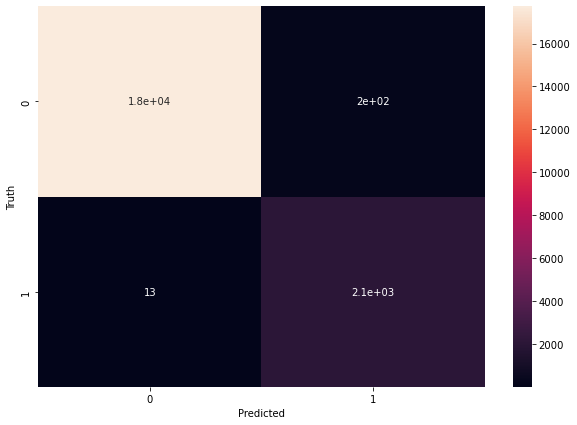

In [202]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [208]:
# save the model to disk
import joblib

filename = 'model.sav'
joblib.dump(rfc, filename)

['model.sav']

In [209]:
import joblib
model = joblib.load('model.sav')

In [210]:
model.predict([[0.289185, 1, 0, 0.509437, 0.589185]])

array([1], dtype=int64)

In [27]:
# Neural network could be considered as tool to increase accuracy of classification. 
# That network would have only one neuron on last output layer which be equal as binary classification.

In [211]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

number_features = 5
initial_type = [('feature_input', FloatTensorType([None , number_features]))]
onnx = convert_sklearn(model, initial_types=initial_type)
with open("model.onnx", "wb") as f:
    f.write(onnx.SerializeToString())

In [212]:
import onnxruntime as rt
import numpy
sess = rt.InferenceSession("model.onnx")

In [213]:
input_name = sess.get_inputs()[0].name
input_name

'feature_input'

In [214]:
label_name = sess.get_outputs()[0].name
label_name

'output_label'

In [215]:
# pred_onx = sess.run([label_name], {input_name: numpy.array(X_test, dtype=numpy.float32)})[0]
pred_onx = sess.run([label_name], {input_name: X_test.values.astype(numpy.float32)})[0]

In [216]:
pred_onx

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [217]:
sess.get_outputs()[0].shape

[None]

In [219]:
X_test

,StatusCode,Connected,Riso,PerformanceRatio,Temp
75721,-0.022553,1,1,0.817586,0.798267
80184,-0.923128,1,0,0.423870,0.570652
19864,1.120485,1,0,0.702358,-0.738138
76699,-1.563922,0,0,0.685920,0.229228
92991,-1.408054,0,1,0.093693,1.253499
...,...,...,...,...,...
32595,-1.719791,1,1,0.357504,1.481114
29313,-0.057191,1,0,0.094928,0.286132
37862,1.085847,0,0,0.554470,1.594922
53421,1.501498,0,1,0.005284,-1.705505
